In [10]:
BATCH_SIZE = 32
MAX_LEN = 716
EMBEDDING_DIMS = 300

In [11]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN], dtype=tf.float32),
            'Y': tf.FixedLenFeature((9,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [16]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN])
    
    return X, Y

In [17]:
%%time

x_train, y_train = iterator('train_with_sp.tfrecord', 5893)
x_test, y_test = iterator('test_with_sp.tfrecord', 1474)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 2.81 s, sys: 617 ms, total: 3.43 s
Wall time: 2.51 s


In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 716), (5893, 9), (1474, 716), (1474, 9))

In [19]:
hidden_dims = 50
epochs = 5

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, Flatten
from keras.layers.wrappers import Bidirectional

model = Sequential()
model.add(Embedding(8001, EMBEDDING_DIMS, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(hidden_dims, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(9, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 716, 300)          2400300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 716, 100)          140400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 716, 100)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 71600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 644409    
Total params: 3,185,109
Trainable params: 3,185,109
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [22]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/5
5893/5893 [==============================] - 658s 112ms/step - loss: 0.6395 - acc: 0.7767 - val_loss: 0.2882 - val_acc: 0.9098
Epoch 2/5
5893/5893 [==============================] - 655s 111ms/step - loss: 0.0513 - acc: 0.9857 - val_loss: 0.2174 - val_acc: 0.9355
Epoch 3/5
5893/5893 [==============================] - 662s 112ms/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.2216 - val_acc: 0.9396
Epoch 4/5
5893/5893 [==============================] - 657s 111ms/step - loss: 0.0043 - acc: 0.9992 - val_loss: 0.2143 - val_acc: 0.9430
Epoch 5/5
5893/5893 [==============================] - 640s 109ms/step - loss: 3.4669e-04 - acc: 1.0000 - val_loss: 0.2129 - val_acc: 0.9450
CPU times: user 1h 32min 26s, sys: 21min 14s, total: 1h 53min 41s
Wall time: 54min 35s


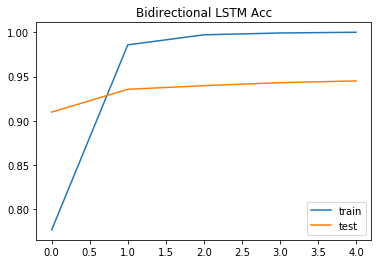

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Bidirectional LSTM Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

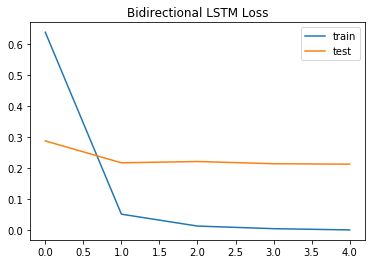

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.927     0.937     0.932       175
  it-life-hack      0.908     0.961     0.934       154
 kaden-channel      0.976     0.970     0.973       167
livedoor-homme      0.922     0.728     0.814       114
   movie-enter      0.945     0.983     0.963       174
        peachy      0.899     0.924     0.912       184
          smax      0.989     0.984     0.987       186
  sports-watch      0.981     0.969     0.975       163
    topic-news      0.951     0.981     0.966       157

     micro avg      0.945     0.945     0.945      1474
     macro avg      0.944     0.937     0.939      1474
  weighted avg      0.945     0.945     0.944      1474



Normalized confusion matrix
[[0.937 0.    0.    0.023 0.006 0.034 0.    0.    0.   ]
 [0.013 0.961 0.    0.    0.    0.013 0.006 0.    0.006]
 [0.006 0.018 0.97  0.    0.    0.006 0.    0.    0.   ]
 [0.018 0.079 0.026 0.728 0.061 0.07  0.    0.    0.018]
 [0.    0.    0.    0.    0.983 0.011 0.    0.006 0.   ]
 [0.043 0.    0.005 0.016 0.005 0.924 0.    0.    0.005]
 [0.    0.016 0.    0.    0.    0.    0.984 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.006 0.969 0.025]
 [0.    0.    0.    0.    0.006 0.    0.    0.013 0.981]]


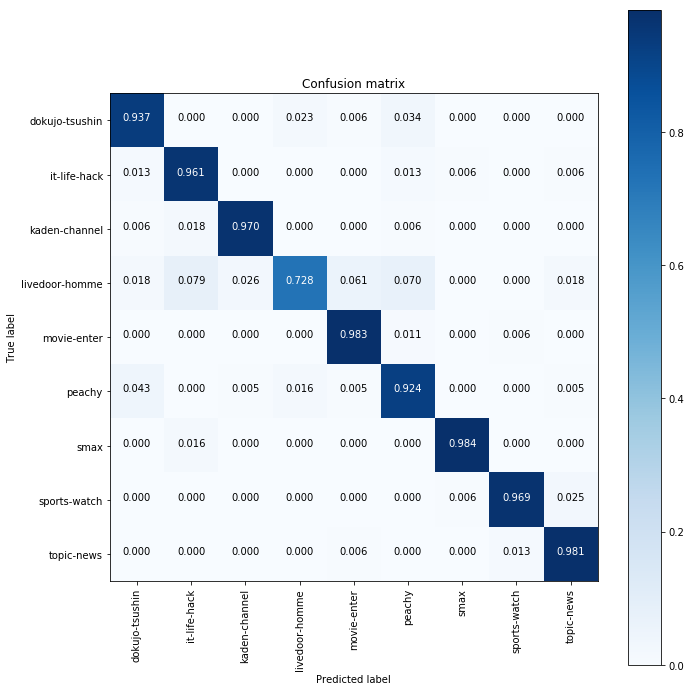

In [27]:
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)